In [ ]:
# %reset -f
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

dist_to_root = 0    # the distance to project root folder
_project_root = Path.cwd().parents[dist_to_root]
if str(_project_root) not in sys.path:
    sys.path.insert(0, str(_project_root))
    
from utils import multiple_split, load_parameters, split_helper, restrict_group_samples, lgb_optimize, split_without_overlap, select_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pickle
from functools import partial
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import optuna
from pathlib import Path

optuna.logging.set_verbosity(optuna.logging.WARNING)

random_seed = 42
np.random.seed(random_seed)

In [6]:
# load the parameters from file ---------------------------------------------------------
params = load_parameters('parameters.yaml')

dataset: nasa
labels: ['capacity']
features: ['voltage', 'temperature', 'power', 'current', 'discharge_power_rate', 'discharge_current_rate', 'discharge_voltage_rate', 'sum_relativeTime', 'range_voltage', 'range_current', 'range_temperature', 'step_length', 'duration', 'delta_current', 'delta_voltage', 'delta_temperature']
data_groupby: ['cycle']
num_trials: 2000
overlap_mode: no
split_size: 20
multi_split_size: [5, 10, 15, 20, 30, 40, 50, 70, 100]
num_restricted: 20


In [7]:
# data read path
processed_data_folder = Path(f'data_{params.dataset}')/f'{len(params.features)}features_9splits'
# processed_data_folder = Path(f'data_{params.dataset}')/'bySOCrange'
print(f'load data from {processed_data_folder}')

# data save path 
model_save_folder = Path(f'model_{params.dataset}')
model_save_folder.mkdir(parents=True, exist_ok=True)

load data from data_nasa/16features_9splits


In [ ]:
# load the data
dfs = {}
for prefix in ['train', 'valid', 'test']:
    csv_files = processed_data_folder.glob(f'{prefix}*.csv')
    dfs[prefix] = pd.concat(
        (pd.read_csv(f) for f in csv_files),
        ignore_index=True
    )
train, valid, test = dfs['train'], dfs['valid'], dfs['test']

In [9]:
# get the training data and validating data
x = train[params.features]
y = train[params.labels].squeeze()
vx = valid[params.features]
vy = valid[params.labels].squeeze()

# get the test data
test_x = test[params.features]
test_y = test[params.labels]

In [ ]:
model_list,selected_feature = select_features(x, y, vx, vy, test_x, test_y)

# get the training data and validating data
selected_features =  selected_feature[:3]
x = train[selected_features]
y = train[params.labels]
vx = valid[selected_features]
vy = valid[params.labels]

# get the test data
test_x = test[selected_features]
test_y = test[params.labels]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3835
[LightGBM] [Info] Number of data points in the train set: 14279, number of used features: 16
[LightGBM] [Info] Start training from score 1.572685
INFO -----> Selected Important Features: ['discharge_voltage_rate', 'voltage']
RESU -----> MAE found =  0.18159718777474282
     Test MAE: 0.06776304596425982
     Memory used (MB): 0.0
     Time elapsed (s): 0.0638432502746582
     CPU usage (%): 135

INFO -----> Selected Important Features: ['discharge_voltage_rate', 'voltage', 'temperature']
RESU -----> MAE found =  0.16822790907803276
     Test MAE: 0.0544199474086664
     Memory used (MB): 0.0
     Time elapsed (s): 0.055336713790893555
     CPU usage (%): 149

INFO -----> Selected Important Features: ['discharge_voltage_rate', 'vol

In [12]:
# find the best hyperparameters of lightgbm model
study_nasa = optuna.create_study(direction="minimize")
study_nasa.optimize(lambda trial: lgb_optimize(trial, x, y, vx, vy), n_trials=params.num_trials, n_jobs=-1, show_progress_bar=True)
best_hyperparameters = study_nasa.best_params
print(f"Best hyperparameters: {best_hyperparameters}")

# fit the model using the combination of training data and validation data
best_model = lgb.LGBMRegressor(**best_hyperparameters)
best_model.fit(x, y)

Best trial: 728. Best value: 0.0256843: 100%|██████████| 2000/2000 [14:02<00:00,  2.37it/s]


Best hyperparameters: {'learning_rate': 0.1467524700955362, 'max_depth': 20, 'num_leaves': 32, 'min_child_samples': 2, 'subsample': 0.8365941462132247, 'colsample_bytree': 0.9272815100512961, 'reg_alpha': 0.00943156577063406, 'reg_lambda': 9.070034968482966, 'n_estimators': 500}


LGBMRegressor(colsample_bytree=0.9272815100512961,
              learning_rate=0.1467524700955362, max_depth=20,
              min_child_samples=2, n_estimators=500, num_leaves=32,
              reg_alpha=0.00943156577063406, reg_lambda=9.070034968482966,
              subsample=0.8365941462132247)

In [17]:
# test the model
pred = best_model.predict(test_x)
mae = mean_absolute_error(test_y, pred)
print("mae on the test set:", mae)

mae on the test set: 0.028748617750313482


In [ ]:
max_capacity = 1.856487

0.015844097845216863

In [ ]:
# save the model
mae_decimal_part = f"{mae:.6f}".split('.')[1]
# model_name = f'{params.dataset}_bySOC_{int(mae)}_{mae_decimal_part}.pkl'
model_name = f'{params.dataset}_{len(selected_features)}features_first{params.num_restricted}_{int(mae)}_{mae_decimal_part}.pkl'

with open(model_save_folder/model_name, 'wb') as f:
    pickle.dump(best_model, f)
print(f'already saved into {model_save_folder/model_name}')

already saved into model_nasa/nasa_16features_first20_0_028749.pkl


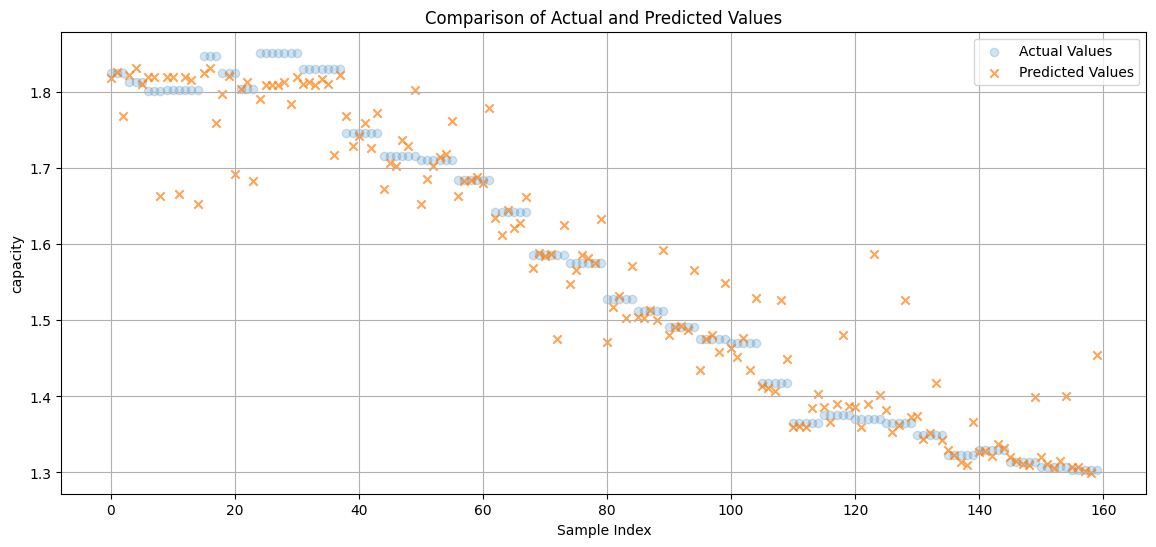

In [19]:
actual_values = test_y
predicted_values = pred
plt.figure(figsize=(14,6))

predicted_values = pd.Series(predicted_values)
plt.scatter(actual_values.index, actual_values.values, label='Actual Values', marker='o', alpha=0.2)
plt.scatter(predicted_values.index, predicted_values.values, label='Predicted Values', marker='x', alpha=0.7)

plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(params.labels[0])
plt.legend()
plt.grid(True)
plt.show()

In [44]:
def generate_test_eachN(each_N):
    data = pd.read_csv('../data/data_nasa/test.csv')
    # test_func = partial(split_cycle_data_no_missing, threshold=each_N)
    test_func = partial(split_without_overlap, split_size=each_N)    
    test = split_helper(data, params.data_groupby, selected_features, params.labels, test_func)
    test_x = test[selected_features]
    test_y = test[params.labels]
    return test_x,test_y

mae_dict = {}
for N in [5,10,20,30,50]:
    print(f"N = {N}")
    # test_x,test_y = generate_test_firstN(N)
    test_x,test_y = generate_test_eachN(N)
    pred = best_model.predict(test_x)
    # if N==30:
    #     plot_res(pred,test_y)
    #     plotresult(pred,test_y)
    r2 = r2_score(test_y, pred)
    print(f"R²: {r2:.4f}")
    mae = mean_absolute_error(test_y, pred)
    mae_dict[N] = mae
    print(f"mae on the test set: {mae:.20f}")
    print('--------------------------------------------')

N = 5
R²: 0.9556
mae on the test set: 0.02460944787310338777
--------------------------------------------
N = 10
R²: 0.9631
mae on the test set: 0.02203148094867412796
--------------------------------------------
N = 20
R²: 0.9661
mae on the test set: 0.01952928357032997567
--------------------------------------------
N = 30
R²: 0.9575
mae on the test set: 0.02235595789791762489
--------------------------------------------
N = 50
R²: 0.9385
mae on the test set: 0.02874861775031348210
--------------------------------------------


In [ ]:
# Get feature importance
importances = best_model.feature_importances_

# Combine feature names and importance values
feature_importance_pairs = list(zip(params.features, importances))

# Sort by importance values in descending order
sorted_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print the sorted results
for feature, importance in sorted_pairs:
    print(f"{feature}: {importance:.1f}")

range_temperature: 5706.0
discharge_voltage_rate: 5324.0
voltage: 4909.0
